## Vizualize results for star pattern. 

* This relates to the synthetic data of emitters arranged in a star pattern.
* Outputs from multi-emitter fitting, RL algorithm, and CNN are compared.
* KLD and MAE metrics are evaluated.
* Output is presented as Fig. 3 in the paper and here we produce its panels.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

import scipy.ndimage as ndi
from scipy.stats import entropy
import h5py

with h5py.File('rl_star.h5', 'r') as h5f:
    rldata = np.array(h5f['star_vs_snr'])

with h5py.File('cnn_output_star.h5', 'r') as h5f:
    cnndata = np.array(h5f['star_vs_snr']).reshape((-1,200,200))

with h5py.File('input_for_cnn_star.h5') as h5f:
    noisydata = np.array(h5f['star_vs_snr']).reshape((-1,50,50))

with h5py.File('star_reference.h5') as h5f:
    refdata = np.array(h5f['star_vs_snr'])

with h5py.File('storm_render.h5') as h5f:
    thstdata = np.array(h5f['siemens_vs_snr'])

def norm(a):
    asu = a - np.min(a)
    norm = np.sum(asu)    
    if norm == 0:
        #for zero-array, skip normalization (to avoid zero-division)
        return np.zeros_like(a)
    return asu/norm

def norm_stack(stack):
    return np.array([norm(img)+1e-10 for img in stack])

def make_mask(stack):
    return np.array([np.sum(img)>0 for img in stack])

#Select only MEF results with at least one emitter.
#Zero-emitter results are considered outright wrong.
thstmask = make_mask(thstdata)
thstdata = norm_stack(thstdata)

#Further infos about references.
info = np.load('star_truth_info.npz')
print(info.files)
snrs = info['snrs']
xys = info['xys']

['snrs', 'xys']


In [2]:
# Image similarity metrics

def nMAE(imA, imB, blur=1):
    imAn = norm(ndi.gaussian_filter(imA, blur))
    imBn = norm(ndi.gaussian_filter(imB, blur))
    return np.mean(np.abs(imAn.ravel() - imBn.ravel()))

# def nMSE(imA, imB, blur=1):
#     imAn = norm(ndi.gaussian_filter(imA, blur))
#     imBn = norm(ndi.gaussian_filter(imB, blur))
#     return np.mean((imAn.ravel() - imBn.ravel())**2)

# def nSSIM(imA, imB, blur=1):
#     imAn = norm(ndi.gaussian_filter(imA, blur))
#     imBn = norm(ndi.gaussian_filter(imB, blur))    
#     return ski.metrics.structural_similarity(imAn, imBn, data_range=1)
    
def nKLD(im_test, im_ref, blur=1, prevent_infty=True):
    imAn = norm(ndi.gaussian_filter(im_test, blur).ravel()) #+ 1e-9 #tested distribution
    if prevent_infty:
        imAn += 1e-10 #this is the value that adds the CNN to dark pixels, this is typical background value for CNN output
    imBn = norm(ndi.gaussian_filter(im_ref, blur).ravel()) #+ 1e-9 #reference distribution    
    #order here is important, first comes reference
    return entropy(imBn/np.sum(imBn), imAn/np.sum(imAn), base=2)

BLUR = 2
measures = {
    'MAE' : lambda x, y : nMAE(x, y, BLUR),
    'KLD' : lambda x, y : nKLD(x, y, BLUR)
}


In [3]:
reconst_methods = {
    'cnn' : cnndata,
    'rl' : rldata,
    'thst' : thstdata
    }

metrics_results = dict()
for rkey in reconst_methods:
    tested_dataset = reconst_methods[rkey]
    datalines = []
    for mkey in measures:
        compount_key = f'{rkey}/{mkey}'
        foo = measures[mkey]
        subresults = np.array([foo(imtest, imref) for imtest, imref in zip(tested_dataset, refdata)])
        metrics_results[compount_key] = subresults.reshape((-1,10))

with h5py.File('star_saved_metrics.h5', 'w') as h5f:
    for ckey in metrics_results.keys():
        h5f.create_dataset(ckey, data = metrics_results[ckey])


In [ ]:
# Select MEF results that actually contained at least one emitter.
storm_mask = np.all(thstmask.reshape((-1,10)), axis=1)
storm_mask

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

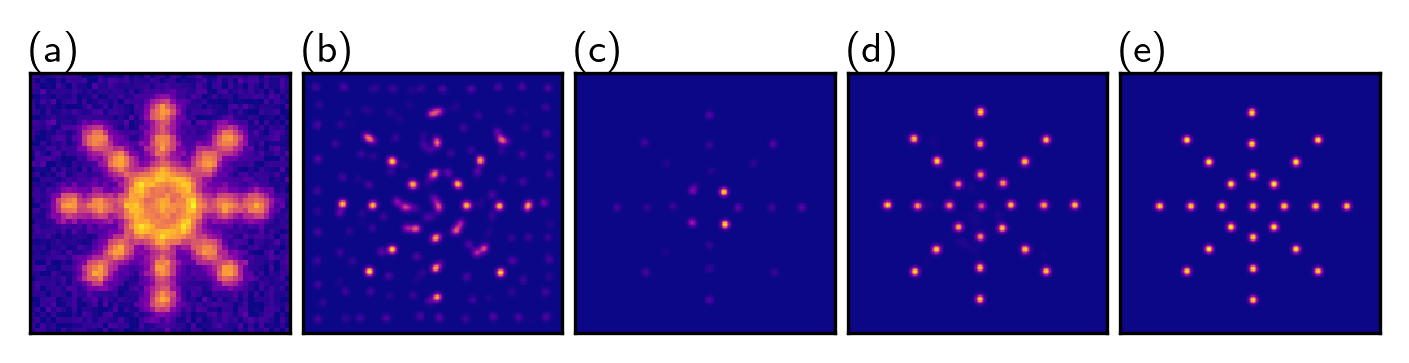

In [6]:
plt.rcParams.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'lines.linewidth': 1,
    'lines.markersize' : 4,
    'font.size': 11,
    'text.usetex' : True,
    'font.size': 10,         # Default font size for all text
    'axes.labelsize': 10,    # Labels (x and y axes)
    'xtick.labelsize': 8,    # Tick labels on x-axis
    'ytick.labelsize': 8,    # Tick labels on y-axis
    'legend.fontsize': 9,    # Legend font size
})

frame = 44
images = [dset[frame] for dset in (noisydata, rldata, thstdata, cnndata, refdata)]

fig, ax = plt.subplots(1,5, figsize=(5,3), dpi=300)
BLUR = 2

for axi, panel, img in zip(ax, 'abcde', images):   
    if panel=='a':
        blurred = img
    else:
        blurred = ndi.gaussian_filter(img, BLUR)
    axi.matshow(blurred, cmap='plasma')
    axi.set_xticks([])
    axi.set_yticks([])
    axi.text(0,1.05,f'({panel})', transform=axi.transAxes)
plt.subplots_adjust(wspace=0.05, top=1.05, left=0)
plt.savefig('star_plasma.pdf')
plt.show()

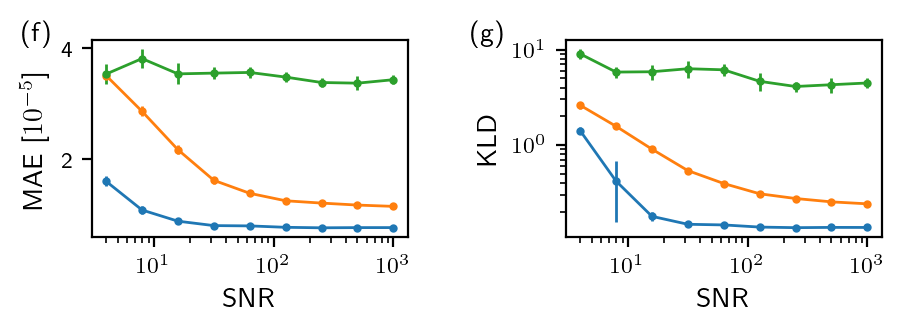

In [7]:
plt.rcParams.update({
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'lines.linewidth': 1,
    'lines.markersize' : 4,
    'font.size': 11,
    'text.usetex' : True,    
    'font.size': 10,         # Default font size for all text
    'axes.labelsize': 10,    # Labels (x and y axes)
    'xtick.labelsize': 8,    # Tick labels on x-axis
    'ytick.labelsize': 8,    # Tick labels on y-axis
    'legend.fontsize': 9,    # Legend font size
})
def log_formatter(val, pos):
    return f"{int(val)}"

storm_mask = np.all(thstmask.reshape((-1,10)), axis=1)

fig, ax = plt.subplots(1,2, sharex=True, figsize=(5,1.7), dpi=200)
SIGMA = 3 #how many sigma is error bar
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
xaxis = snrs.reshape((-1,10))[:,0]
yscale = 1e5

for axi, mkey in zip(ax, measures):
    for rkey, clr in zip(reconst_methods, colors):
        ckey = f'{rkey}/{mkey}'
        ymean = np.mean(metrics_results[ckey], axis=1)
        ystd = np.std(metrics_results[ckey], axis=1)

        # set scale for plotting MAE
        if axi == ax[0]:  
            ymean *= yscale
            ystd *= yscale

        ylo = ymean - ystd*SIGMA
        yhi = ymean + ystd*SIGMA
        if rkey=='thst':
            axi.errorbar(xaxis[storm_mask], ymean[storm_mask], yerr=ystd[storm_mask], fmt=".-", label=f'{rkey}')
        else:
            axi.errorbar(xaxis[2:], ymean[2:], yerr=ystd[2:], fmt=".-", label=f'{rkey}')
    axi.set_xscale('log')
    if mkey == 'KLD':
        axi.set_yscale('log')
    # axi.set_ylabel(mkey)
#ax[-1].legend()

ax[0].set_yticks([2,4], labels=[2,4])

ax[1].set_xlabel('SNR')
ax[0].set_xlabel('SNR')
ax[1].set_ylabel('KLD')
ax[0].set_ylabel('MAE [$10^{-5}$]')
# ax[0].yaxis.set_major_formatter(FuncFormatter(log_formatter))  #yaxis.set_major_formatter(ScalarFormatter()) 


ax[1].set_xlabel('SNR')
ax[0].set_xlabel('SNR')

ax[0].text(-0.22,1.0,f'(f)', transform=ax[0].transAxes)
ax[1].text(-0.3,1.0,f'(g)', transform=ax[1].transAxes)

# ax[-1].set_ylim(0,5)
plt.subplots_adjust(wspace=0.5, bottom=0.3, left=0.2, right=0.99)
#plt.savefig('images/panel_f_g.pdf')
# plt.savefig('star_metrics.png', bbox_inches='tight')
plt.savefig('star_metrics.pdf', bbox_inches='tight')
plt.show()

        